## Part 3: NN + NLP + Multiple Inputs
## Libraries

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re

# For ML
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif


# Keras
import tensorflow as tf

# GPU memory
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations


# Charts and images
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## Functions

In [ ]:
# Метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = pd.read_csv('data.csv')
sample_submission = pd.read_csv(r'data/sample_submission.csv')

In [ ]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,model,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,mileage_prod_date,mileage_owns,owns_year
0,универсал 5 дв.,MERCEDES,чёрный,300 задний w124 бензин черный mercedes универс...,3.0,220,бензин,350000,1984,W124,5,1991,1099427284,автоматическая,3,Оригинал,задний,0,0.0,300,0,0,0,0,0,0,0,0,0,0,0,0,11666,116666,10
1,купе,BMW,белый,640d полный 6er дизель белый bmw купе любимый...,3.0,313,дизель,15000,2011,6ER,2,2013,1096405886,автоматическая,1,Оригинал,полный,0,0.0,640d,1,0,0,0,0,0,0,0,0,0,0,0,1875,15000,8
2,купе,BMW,пурпурный,325xi полный 3er бензин пурпурный bmw купе пе...,2.5,218,бензин,166600,2005,3ER,2,2008,1100195294,автоматическая,3,Оригинал,полный,0,0.0,325xi,0,0,0,0,0,0,0,0,0,0,0,0,12815,55533,4
3,седан,BMW,белый,318i задний 3er бензин белый bmw седан отличн...,2.0,136,бензин,147000,2005,3ER,4,2007,1099827282,автоматическая,2,Оригинал,задний,0,0.0,318i,0,0,0,0,0,0,0,0,0,0,0,0,10500,73500,7
4,седан,BMW,чёрный,520d полный 5er дизель черный bmw седан немка...,2.0,190,дизель,24000,2016,5ER,4,2019,1100076198,автоматическая,1,Оригинал,полный,0,0.0,520d,1,0,0,0,0,0,0,0,0,0,0,0,12000,24000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,седан,BMW,серый,320i задний 3er бензин серый bmw седан любимы...,2.0,150,бензин,232777,2005,3ER,4,2006,1100036650,автоматическая,3,Оригинал,задний,1,550000.0,320i,0,0,0,0,0,0,0,0,0,0,0,0,15518,77592,5
8346,седан,BMW,чёрный,520d задний 5er дизель черный bmw седан офици...,2.0,190,дизель,33700,2013,5ER,4,2016,1090506038,автоматическая,3,Оригинал,задний,1,1900000.0,520d,0,0,0,0,0,0,0,0,0,0,0,0,6740,11233,1
8347,седан,BMW,белый,318i задний 3er бензин белый bmw седан торг м...,2.0,143,бензин,200000,2008,3ER,4,2008,1095155628,автоматическая,3,Оригинал,задний,1,530000.0,318i,0,0,0,0,0,0,0,0,0,0,0,0,15384,66666,4
8348,седан,AUDI,чёрный,long полный a8 бензин черный audi седан отлич...,3.0,310,бензин,72000,2013,A8,4,2016,1099625256,автоматическая,3,Оригинал,полный,1,1970000.0,Long,0,0,0,0,0,1,0,0,0,0,0,0,14400,24000,1


## PreProc Tabular Data

In [ ]:
# Категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод',
    'model'
]

# Числовые признаки
numerical_features = [
    'engineDisplacement',
    'mileage',
    'modelDate',
    'mileage_prod_date',
    'mileage_owns',
    'owns_year',
    'productionDate',
    'enginePower'
]

In [ ]:
def preproc_data(df_input):

    df_output = df_input.copy()

    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis=1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,mileage_prod_date,mileage_owns,owns_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,model_20,model_21,model_22,model_23,model_24,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34,model_35,model_36,model_37,model_38,model_39,model_40,model_41,model_42,model_43,model_44,model_45,model_46,model_47,model_48,model_49,model_50,model_51,model_52,model_53,model_54,model_55,model_56,model_57,model_58,model_59,model_60,model_61,model_62,model_63,model_64,model_65,model_66,model_67,model_68,model_69,model_70,model_71,model_72,model_73,model_74,model_75,model_76,model_77,model_78,model_79,model_80,model_81,model_82,model_83,model_84,model_85,model_86,model_87,model_88,model_89,model_90,model_91,model_92,model_93,model_94,model_95,model_96,model_97,model_98,model_99,model_100,model_101,model_102,model_103,model_104,model_105,model_106,model_107,model_108,model_109,model_110,model_111,model_112,model_113,model_114,model_115,model_116,model_117,model_118,model_119,model_120,model_121,model_122,model_123,model_124,model_125,model_126,model_127,model_128,model_129,model_130,model_131,model_132,model_133,model_134,model_135,model_136,model_137,model_138,model_139,model_140,model_141,model_142,model_143,model_144,model_145,model_146,model_147,model_148,model_149,model_150,model_151,model_152,model_153,model_154,model_15

### Split data

In [ ]:
# Выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Model 4: NLP + Multiple Inputs

In [ ]:
data.description

0       300 задний w124 бензин черный mercedes универс...
1        640d полный 6er дизель белый bmw купе любимый...
2        325xi полный 3er бензин пурпурный bmw купе пе...
3        318i задний 3er бензин белый bmw седан отличн...
4        520d полный 5er дизель черный bmw седан немка...
                              ...                        
8345     320i задний 3er бензин серый bmw седан любимы...
8346     520d задний 5er дизель черный bmw седан офици...
8347     318i задний 3er бензин белый bmw седан торг м...
8348     long полный a8 бензин черный audi седан отлич...
8349     pullman задний s klasse бензин черный mercede...
Name: description, Length: 8350, dtype: object

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 969 ms, sys: 9.38 ms, total: 978 ms
Wall time: 990 ms


In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape)

(5677, 256) (1002, 256) (1671, 256)
CPU times: user 870 ms, sys: 5.54 ms, total: 875 ms
Wall time: 874 ms


In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

 50i полный x6 бензин черный bmw внедорожник 5 дв идеальный состояние самый полный комплектация крашеный деталь полностью заводской окрас обслуживание официальный дилер bmw 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.25))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     5820928     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(
    r'/working/best_model.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 9s 404ms/step - loss: 99.9966 - MAPE: 99.9966 - val_loss: 99.8767 - val_MAPE: 99.8767

Epoch 00001: saving model to /working/best_model.hdf5
Epoch 2/500
12/12 [==============================] - 4s 318ms/step - loss: 99.3949 - MAPE: 99.3949 - val_loss: 94.6087 - val_MAPE: 94.6087

Epoch 00002: saving model to /working/best_model.hdf5
Epoch 3/500
12/12 [==============================] - 4s 313ms/step - loss: 87.9175 - MAPE: 87.9175 - val_loss: 51.9326 - val_MAPE: 51.9326

Epoch 00003: saving model to /working/best_model.hdf5
Epoch 4/500
12/12 [==============================] - 4s 308ms/step - loss: 51.5674 - MAPE: 51.5674 - val_loss: 46.1123 - val_MAPE: 46.1123

Epoch 00004: saving model to /working/best_model.hdf5
Epoch 5/500
12/12 [==============================] - 4s 307ms/step - loss: 47.4140 - MAPE: 47.4140 - val_loss: 43.5409 - val_MAPE: 43.5409

Epoch 00005: saving model to /working/best_model.hdf5
Epoch 6/500
12/12 [===========

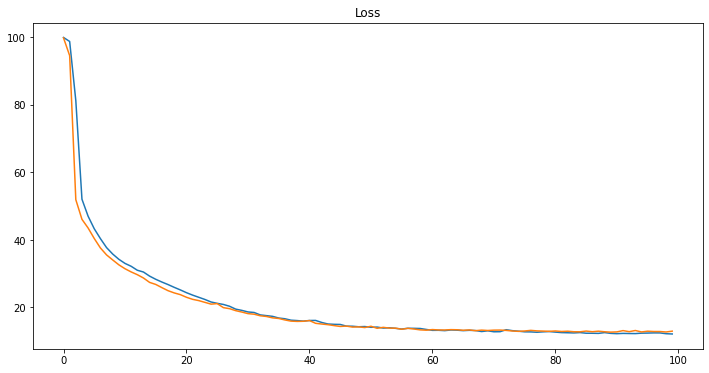

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights(r'/working/best_model.hdf5')
model.save(r'/working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.98%


In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])

sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv(r'csv/without_round_nn2.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000

sample_submission.to_csv('nn2_submission.csv', index=False)

### Вывод по данной части:
- Построена NLP модель для обработки тестовых описаний автомобиля.
- Данные NLP модели и NN модели объеденены в multiple inputs сеть.
- С помощью обработки текстов описаний удалось улучшить метрику в сравнении с предлагаемым ноутбуком baseline.
- В данной конфигурации достигнут показатель МАРЕ: 12.79%.